In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
random_seed = 777 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
#from torchsummary import summary

In [ ]:
# paths for (labeled) training & validation data.
train_path = '/content/drive/MyDrive/FashionClassification/Train/'
valid_path = '/content/drive/MyDrive/FashionClassification/Validation/'

In [ ]:
# prepare training data set
classes = ['Resort', 'Retro', 'Sporty']

data =[]
label =[]

## i : Integer representation for each classes (Resort/Retro/Sporty -> 0/1/2)
for i, d in enumerate(classes):
    files = os.listdir(train_path+'/'+d)
    
    for f in files:
        img = Image.open(train_path+'/'+d+'/'+f,'r')
        #img = img.resize((224, 224))
        one_img = np.asarray(np.float32(img))
        norm_img = (one_img-np.min(one_img))/(np.max(one_img)-np.min(one_img))
        data.append(norm_img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
        label.append(i)

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
data.shape, label.shape

((7200, 3, 150, 150), (7200,))

In [ ]:
# prepare validation data set
data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+'/'+d)
    
    for f in files:
        img = Image.open(valid_path+'/'+d+'/'+f,'r')
        #img = img.resize((224, 224))
        one_img = np.asarray(np.float32(img))
        norm_img = (one_img-np.min(one_img))/(np.max(one_img)-np.min(one_img))
        data.append(norm_img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
data.shape, label.shape  # check

((1800, 3, 150, 150), (1800,))

In [ ]:
del data, label

In [ ]:
# # Display images
# # Not necessary for training. Just for confirmation
# for images, labels in valid_loader:
#         i, l = Variable(images), Variable(labels)
#         print(i.size())
#         i = i.cpu().numpy()
#         l = l.cpu().numpy()
#         print(f'Label = {l[0]} : {classes[l[0]]}')
#         plt.imshow(i[0,0,:,:])
#         plt.show()

In [ ]:
# Build convolutional neural net
VGG_Network ={
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}
 
# VGG
class VGGnet(nn.Module):
    def __init__(self,model,in_channels = 3, num_classes = 3,init_weights = True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels
 
        # create conv layer , VGG Type
        self.conv_layers = self.create_conv_layer(VGG_Network[model])
 
        self.fcs = nn.Sequential(
            nn.Linear(in_features  = 512*4*4,out_features=4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features = 4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096,num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def forward(self,x):
        out = self.conv_layers(x)
        #print(out.size())
        out = out.view(-1,512*4*4)
        out = self.fcs(out)
        return out
 
    def create_conv_layer(self,Network):
        layers = []
        in_channels = self.in_channels
 
        for x in Network:
            if type(x) == int: # conv layer
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size =(3,3),
                                    stride = (1,1),
                                    padding = (1,1)),
                        nn.BatchNorm2d(x),
                        nn.ReLU()]
                in_channels = x
            elif x == 'M': # maxpooling
                layers += [nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))]
        return nn.Sequential(*layers)
 
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean = 0,std=0.01)
                nn.init.constant_(m.bias,0)
 
model = VGGnet('VGG19', in_channels=3, num_classes=3, init_weights=True)

In [ ]:
# Print the network you built
model.cuda()

VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), 

In [ ]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight decay = )
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
   # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        print('Valid_Prediction : {}'.format(pred))
        print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

In [ ]:
import gc
gc.collect()
# cuda delete cache
torch.cuda.empty_cache()

***START EPOCH***
# Epoch : 0 /150
Valid_Prediction : [0 1 0 1 0 0 2 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 2 0 2 2 2 0 2 0 0
 2 2 0 0 2 1 0 2 0 0 0 1 0 0 0 1 2 1 0 0 0 0 0 1 2 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 2 1 2 0 2 0 0 0 2 0 0 2 0 0 0 0 0 0 1 2 0 0 0 0 0 2 0 0 0 1 0 0 2 2
 0 1 1 0 0 0 0 0 0 2 2 1 2 1 0 0 0 1 2 2 2 0 0 0 2 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 2 2 2 0 2 1 0 0 1 0 2 2 1 0 1 0 2 0 1 1 0 0 2 0 2 0 0 1 2 0 2 1 2 1 1
 1 0 2 1 0 2 0 0 0 1 0 0 1 2 1 2 0 0 0 0 1 0 2 0 2 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 2 0 0 2 0 0 2 2 2 1 0 1 0 2 2 2 0 2 0 0 1 2 2 2 1 0 

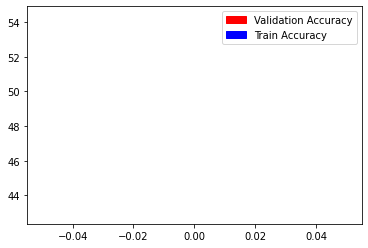

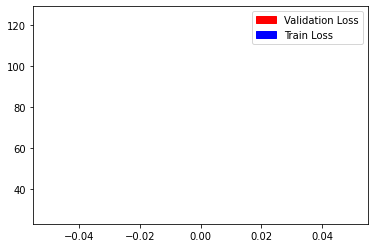

# Epoch : 1 /150
Valid_Prediction : [2 1 0 1 0 0 1 1 2 2 1 2 1 2 0 0 0 2 2 0 1 2 2 2 0 1 2 0 2 0 2 2 2 0 2 0 0
 2 0 0 0 2 1 0 2 0 2 2 2 2 0 0 2 2 1 2 0 0 0 2 2 2 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 2 2 2 2 1 2 2 2 2 0 2 2 0 0 2 2 0 0 2 1 0 2 2 2 2 1 2 0 2 1 2 2 2 2
 2 2 0 0 0 2 2 2 2 2 2 1 1 1 0 0 0 1 1 1 2 0 2 0 2 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 2 2 2 2 1 2 2 1 2 2 1 1 0 1 2 2 2 1 1 1 0 2 2 1 0 2 1 1 0 1 2 2 1 1
 1 2 2 1 0 2 2 0 2 1 2 0 1 2 1 2 2 0 2 2 1 0 2 2 2 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 2 0 2 2 2 2 2 2 2 2 2 2 1 0 1 2 2 1 1 0 2 0 2 1 1 2 2 2 2 2 0 2 0 0 0 2
 2 0

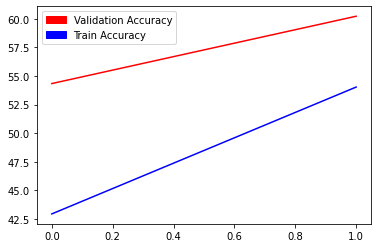

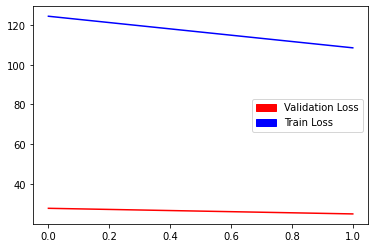

# Epoch : 2 /150
Valid_Prediction : [0 1 0 1 0 0 1 1 2 2 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 2 0 2 0 0 0 2 0 2 0 0
 0 2 0 0 2 1 0 2 0 2 0 1 2 0 0 1 0 1 0 0 0 0 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 2 0 0 1 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 2 0 1 2 0 2 0 0 0 2 0
 0 2 0 0 0 2 0 0 0 0 0 0 1 1 0 0 0 1 1 2 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 2 0 2 0 0 0 0 2 0 2 1 1 0 1 0 1 2 1 1 0 0 2 2 1 0 0 1 1 0 1 2 0 1 1
 1 2 1 0 0 2 0 0 2 1 2 0 1 2 1 0 2 0 0 2 1 1 1 2 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 2 2 2 2 0 0 0 0 0 2 1 0 1 0 2 1 1 0 2 0 0 1 1 0 0 2 2 2 0 2 0 0 0 2
 1 0

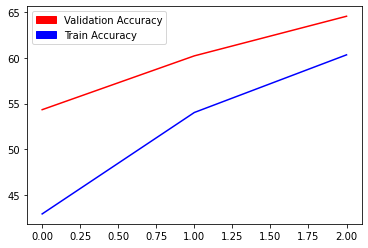

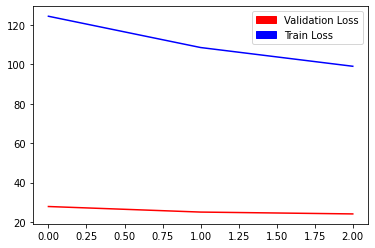

# Epoch : 3 /150
Valid_Prediction : [0 1 0 1 0 0 1 1 0 2 1 2 1 0 2 0 0 2 0 0 2 0 0 2 0 1 2 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 0 0 2 2 2 0 2 2 0 0 2 2 1 2 0 0 0 0 2 2 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 2 0 2 2 2 1 0 2 2 2 0 2 2 2 0 0 2 0 0 0 0 0 2 0 2 2 0 2 2 2 1 2 0 2 0
 0 2 2 0 2 2 0 0 0 2 2 1 0 0 0 0 0 2 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 2 2 2 2 2 0 0 2 0 2 0 1 0 1 2 0 2 1 1 0 2 2 2 1 0 0 2 1 0 0 2 2 1 1
 1 2 0 0 0 0 0 0 0 2 0 0 1 2 2 0 2 0 0 0 0 0 0 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 2 2 0 0 0 0 2 2 0 0 0 0 2 0 1 2 2 0 0 0 0 0 2 2 2 2 0 0 0 0 0 2
 0 0

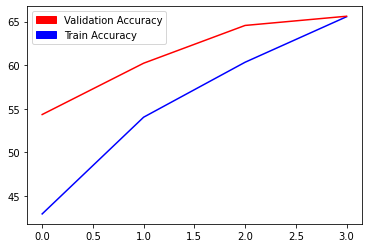

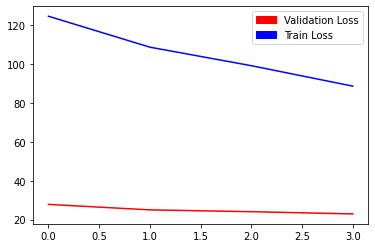

# Epoch : 4 /150
Valid_Prediction : [0 1 0 1 0 0 1 1 1 2 1 0 1 0 0 0 0 1 0 0 1 0 0 2 0 1 0 0 2 0 0 1 2 0 0 2 2
 0 2 0 0 2 0 0 2 1 0 0 2 2 2 2 1 2 0 2 0 2 0 2 2 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 2 2 0 2 0 2 1 0 2 2 0 2 0 0 0 0 0 2 0 0 0 1 0 0 2 2 2 1 0 2 2 1 2 0 2 0
 1 2 2 2 2 2 0 0 0 0 2 0 1 0 2 0 2 2 1 1 0 0 0 1 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 2 0 2 2 1 0 0 1 2 2 1 1 0 1 2 1 2 1 1 0 2 0 0 1 0 2 1 1 0 1 2 1 1 1
 1 2 2 0 0 0 0 1 2 1 0 1 1 2 2 1 2 0 1 0 1 0 2 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 2 0 0 2 0 2 0 1 0 2 2 2 1 1 1 0 2 1 1 2 2 0 2 1 1 2 0 0 2 2 0 2 0 2 0 2
 1 0

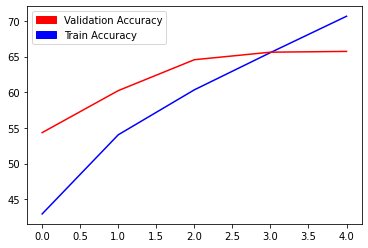

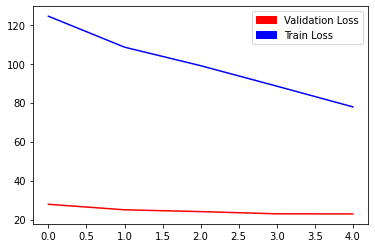

# Epoch : 5 /150
Valid_Prediction : [0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 0 0 0 0 2 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1
 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1
 0 0

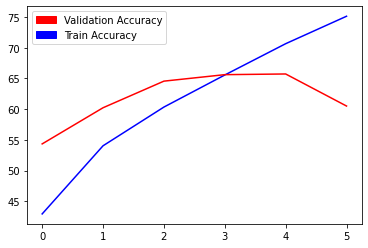

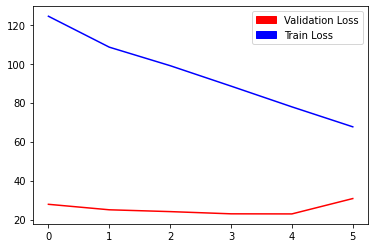

# Epoch : 6 /150
Valid_Prediction : [0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0
 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 1 2 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 0 1 0 0 2 0 0 0 1 0 0 2 0 0 0 1 0 0 0 0 1 0 0 1 0 2 0 2 0 1 1
 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 2 0 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2
 1 0

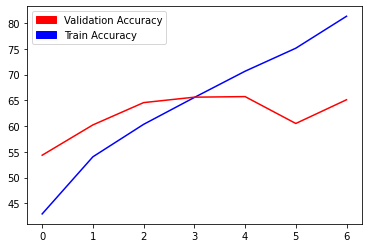

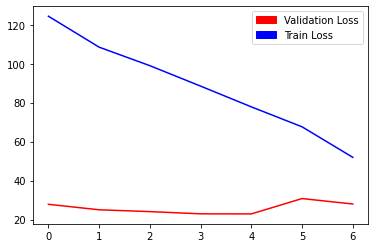

# Epoch : 7 /150
Valid_Prediction : [0 2 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0

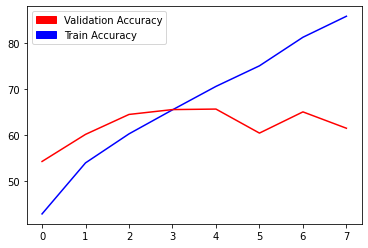

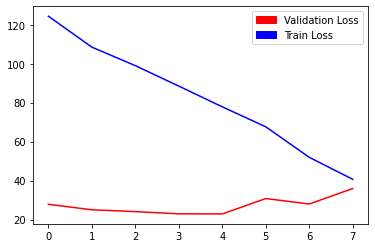

# Epoch : 8 /150
Valid_Prediction : [0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 2 1 0 0 0 2 0 0 0 0 0 0 0 0 2 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 2 0 0 0 0 2 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 2 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 2 0 1 0 0 1 0 1 0 0 0 1 0 1
 0 0

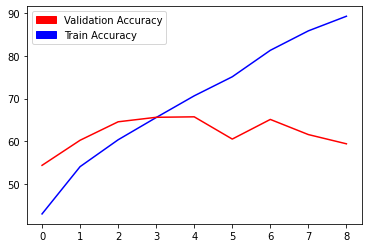

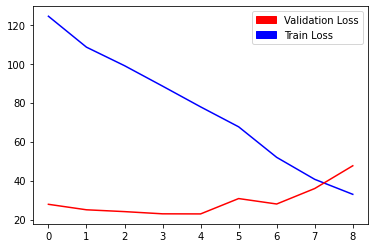

# Epoch : 9 /150
Valid_Prediction : [0 2 2 0 2 0 1 1 0 0 2 0 0 0 0 0 0 1 0 0 1 0 0 0 0 2 0 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 2 0 2 2 0 0 2 0 0 0 2 2 0 2 0 0 0 0 2 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 2 2 2 2 2 0 0 2 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 2 0
 2 2 0 2 0 2 0 0 0 0 0 1 0 0 2 0 0 2 0 2 0 0 2 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 2 0 1 0 2 2 0 0 0 2 0 0 2 2 0 0 2 0 0 2 0 2 1 0 2
 1 2 2 0 0 0 0 0 0 2 0 0 1 2 0 0 0 0 2 0 0 0 0 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 0 0 0 0 0 2 0 0 0 2 2 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 0 1 0 2
 0 0

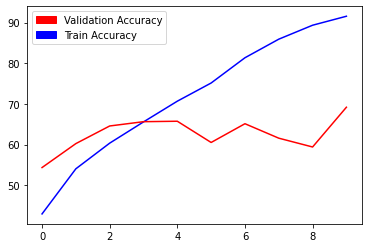

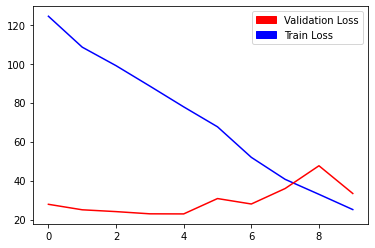

# Epoch : 10 /150
Valid_Prediction : [0 2 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 1 0 2 0 0
 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 2 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 2 1 2 0 2 0 0 0 2 0
 1 0 0 2 0 2 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 2 0 0 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 2 0 0 0 1 0 1
 0 

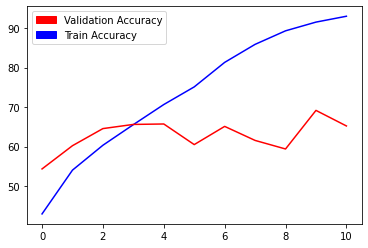

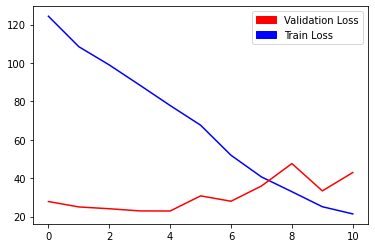

# Epoch : 11 /150
Valid_Prediction : [0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1
 0 

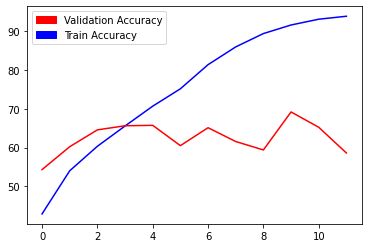

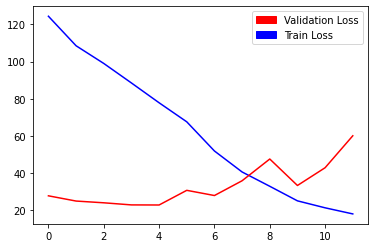

# Epoch : 12 /150
Valid_Prediction : [0 0 0 0 2 0 1 1 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0
 0 0 0 0 2 0 0 2 1 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 0 0 0 0 0
 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 2 0 2 0 0 1 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 0 2 0 0 0 0 0 2 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 

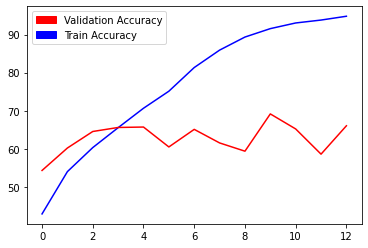

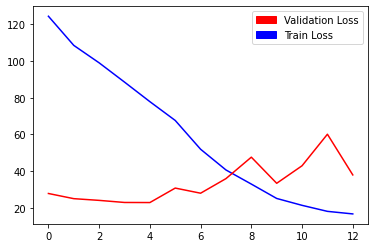

# Epoch : 13 /150
Valid_Prediction : [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 2 2 0 0 0 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 

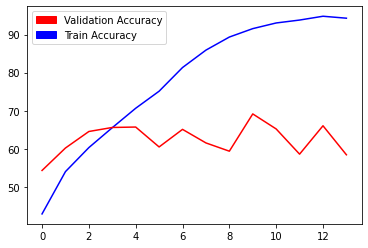

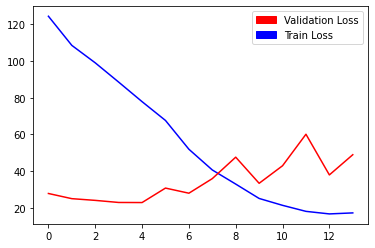

# Epoch : 14 /150
Valid_Prediction : [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 2 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1
 0 

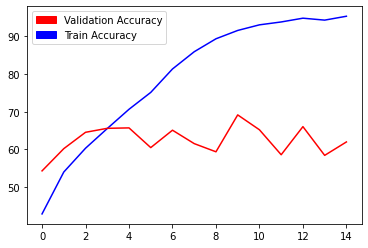

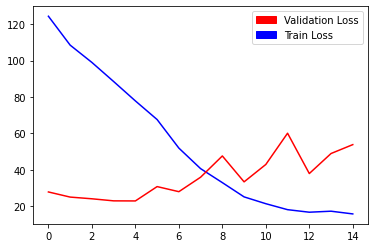

# Epoch : 15 /150
Valid_Prediction : [0 2 0 0 0 2 0 1 2 2 0 0 1 0 0 0 2 1 0 0 1 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0
 0 0 2 0 2 0 0 2 1 2 0 0 2 0 0 2 2 0 2 2 0 2 2 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0 0 0 0
 2 0 0 2 0 2 0 0 0 2 2 0 0 0 2 0 0 2 1 0 0 2 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 2 0 0 2 0 2 0 1 0 0 2 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 2 1 1
 1 0 1 0 0 2 0 0 0 2 0 0 1 2 0 0 2 0 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 1 0 2 0 0 0 0 0 2 0 0 2 0 0 0 2 0 2
 0 

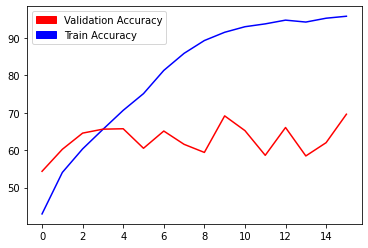

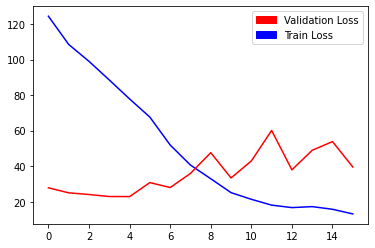

# Epoch : 16 /150
Valid_Prediction : [0 2 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 2 0 0 2 0 1 0 1 0 2 1 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 2 1 1 0 0 0 2 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1
 1 0 1 0 0 0 0 0 0 2 0 1 0 0 0 0 2 0 1 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 

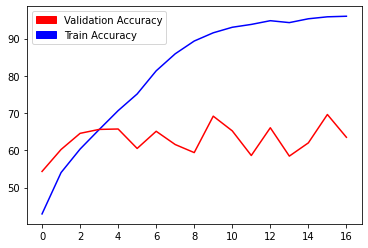

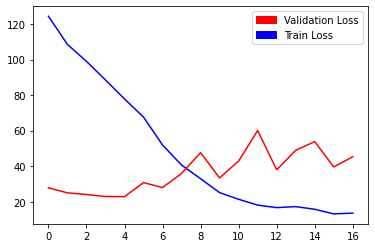

# Epoch : 17 /150
Valid_Prediction : [0 1 0 0 0 0 0 1 0 2 2 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0
 0 0 0 1 2 0 0 2 1 0 0 0 2 0 0 2 0 0 0 2 0 2 1 1 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 2 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 0 1 0 0 2 0 0 0 1 0 2 2 0 0 1 1 0 0 0 0 1 0 2 0 1 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 2
 1 

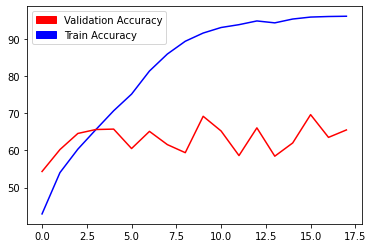

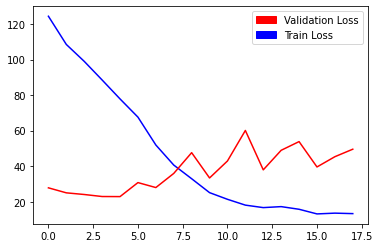

# Epoch : 18 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 0 2 0 1 0 0 0 0 2 2 0 1 0 0 2 0 1 0 0 2 0 2 2 2 0 2 2 0
 0 1 2 1 2 1 0 2 1 2 0 1 2 0 0 2 2 2 2 1 0 0 0 1 0 1 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 2 0 2 2 2 2 2 0 2 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0
 2 2 2 0 0 0 0 0 0 2 2 0 1 0 2 2 2 2 1 1 0 0 0 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 0 0 1 0 0 1 0 2 1 1 0 2 2 1 2 0 1 0 2 0 2 1 0 2 1 1 0 1 2 2 1 1
 1 0 1 1 0 0 0 0 0 2 0 1 1 0 0 0 2 0 1 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 2 0 2 1 0 0 0 2 1 1 0 2 0 0 1 1 0 2 1 0 2 0 0 0 1 0 2
 1 

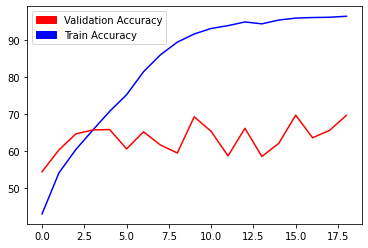

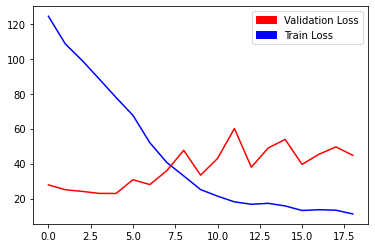

# Epoch : 19 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 2 0 1 0 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 0 0 2 0 2 0 0 2 0 0 0 2 0 2 0 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 0 0 0 2 0 0 2 1 0 0 0 0 1 0 0 1 0 0 0 0 2 1 2 0 0 2 0 0 2 0
 1 2 0 0 0 2 0 0 0 2 2 1 0 0 2 0 0 2 1 1 0 2 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 0 0 0 0 1 0 2 1 1 0 0 2 0 0 0 0 0 0 2 0 1 0 2 1 1 2 0 2 2 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 0 0 0 1 0 0 0 2 1 1 0 1 0 0 1 1 0 0 0 0 2 0 0 0 2 0 2
 1 

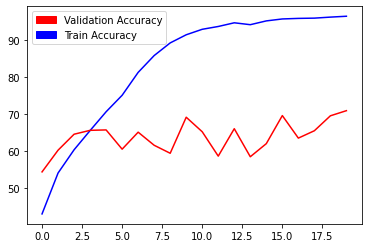

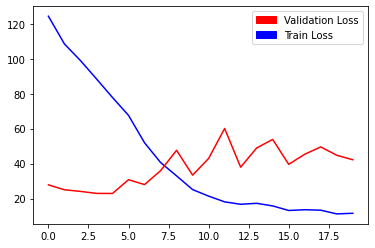

# Epoch : 20 /150
Valid_Prediction : [1 1 2 0 0 2 1 1 0 2 2 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 2 0 2 0 2 1 2 2 2 2 0
 0 0 0 0 2 0 0 2 2 2 0 1 2 0 0 2 2 1 1 1 0 2 1 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 2 0 2 2 2 1 2 0 2 0 1 2 1 0 0 0 2 1 0 0 0 0 0 0 0 2 0 2 0 2 2 0 1 2 0
 2 2 0 0 2 2 2 0 1 1 1 1 1 1 2 1 0 2 1 1 2 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 2 2 0 1 1 2 1 0 1 1 1 0 2 2 1 0 0 1 0 2 0 0 1 0 2 1 1 2 1 2 1 1 0
 1 2 1 0 0 0 0 1 1 2 0 1 1 2 1 2 2 0 1 0 0 1 1 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 2 0 2 0 2 0 2 0 2 2 1 1 2 1 0 1 1 1 1 1 2 0 1 1 2 1 0 1 2 0 0 0 1 0 2
 1 

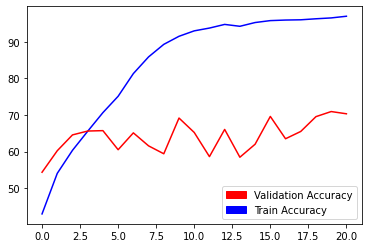

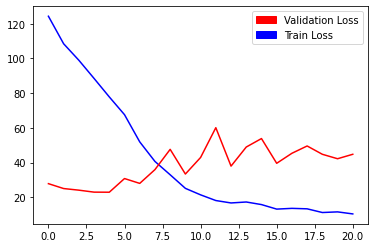

# Epoch : 21 /150
Valid_Prediction : [0 0 0 0 0 2 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 2 0 0 1 2 0 2 0 0
 0 2 0 1 2 0 0 1 1 1 0 1 2 0 0 2 2 0 2 0 0 0 1 1 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 1 2 2 2 0 2 1 0 0 0 2 1 0 0 1 2 1 0 0 1 0 0 0 2 2 1 2 1 2 1 0 1 2 0
 1 0 0 0 0 2 2 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 1 0 0 2 0 1 1 2 1 2 2 1 1 0 0 2 1 0 0 1 1 0 2 2 1 0 2 1 1 2 1 2 1 1 1
 1 2 1 1 0 2 0 0 2 2 0 1 0 2 2 2 1 0 1 0 0 0 1 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 2 2 2 0 0 2 2 2 1 1 1 1 1 1 1 0 2 2 1 1 1 0 1 1 1 2 0 0 0 1 0 2
 1 

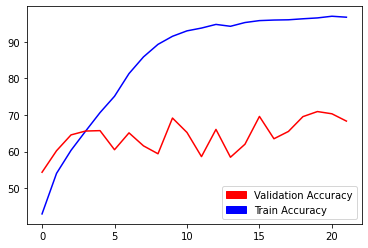

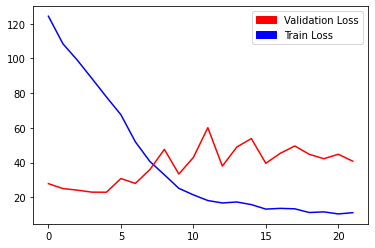

# Epoch : 22 /150
Valid_Prediction : [0 2 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0
 0 0 0 0 2 0 0 2 0 0 0 2 2 0 0 2 0 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 2 0 0 0 0 2 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0
 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 0 0 0 0 2 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2
 0 

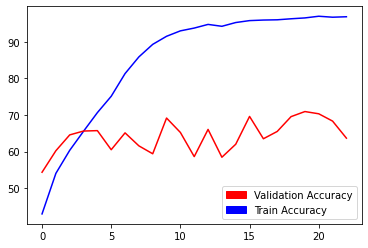

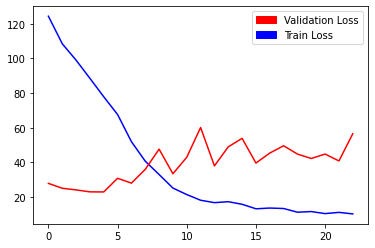

# Epoch : 23 /150
Valid_Prediction : [0 2 0 0 2 0 2 1 1 2 2 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 2 0 2 0 0 0 1 0 0 2 0
 0 1 0 0 2 0 0 2 1 2 0 2 2 0 0 2 2 0 2 0 0 2 1 1 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 0 2 0 0 0 2 0 0 0 0 0 2 1 0 0 0 0 0 0 0 2 0 2 1 0 2 0 0 2 0
 2 0 0 0 2 2 0 0 0 2 2 0 2 0 2 2 0 2 1 2 0 2 0 2 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 1 2 2 2 0 1 1 1 0 2 2 0 0 1 1 0 0 2 2 1 0 2 1 1 2 0 0 2 1 1
 1 2 1 0 0 0 0 0 0 2 0 1 1 2 0 1 2 0 2 0 0 0 2 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 1 0 1 2 2 0 0 0 2 0 2 1 2 2 0 0 0 1 0 0 0 0 1 1 0 2 0 0 0 0 0 0 2 0 2
 2 

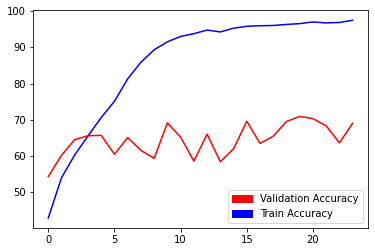

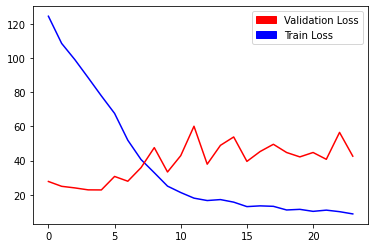

# Epoch : 24 /150
Valid_Prediction : [0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 2 0 0 0 0 2 0 0 1 1 0 0 2 0
 0 0 0 0 0 0 0 2 1 0 0 1 2 0 0 1 0 0 2 2 0 2 2 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 2 0 1 0 2 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 2 1 0 2 0 2 0 0 0 1 0 1 0 0 0 0 2 1 1 0 0 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 0 0 0 1 2 0 1 0 1 0 1 0 0 2 0 0 1 1 0 0 0 0 1 0 2 1 1 2 0 0 1 1 1
 1 2 1 0 0 0 1 0 0 1 0 1 1 0 0 1 2 0 2 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 2 0 0 0 0 0 0 1 0 0 0 1 1 1 0 2 0 0 1 1 0 0 0 0 1 0 0 0 2 0 1
 0 

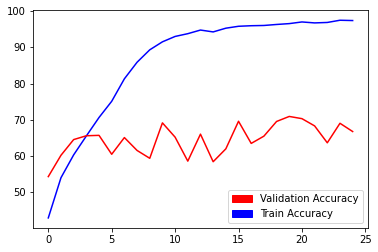

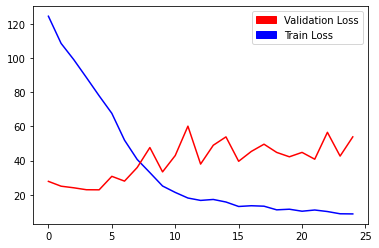

# Epoch : 25 /150
Valid_Prediction : [1 2 1 1 0 2 1 1 2 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 2 1 0 0 2 0 2 2 0
 0 0 0 0 1 1 0 2 1 2 0 1 2 0 0 2 1 1 1 1 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 2 2 2 1 2 0 0 0 1 2 1 0 2 0 2 1 0 0 1 0 0 0 2 2 1 2 0 0 0 0 1 2 0
 1 1 0 0 0 2 0 0 0 1 0 0 1 1 0 2 0 1 1 2 0 2 2 2 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 0 1 0 2 1 0 2 1 1 0 2 2 1 0 1 1 0 0 0 2 1 1 2 1 1 1 0 1 1 1 1
 1 2 1 2 0 0 0 1 2 2 0 1 1 2 1 1 2 0 2 2 0 2 0 2 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 1 0 2 2 0 1 2 1 2 1 1 0 0 1 0 1 0 1 1 0 1 1 0 2 0 2 1 0 0 0 1 0 1
 1 

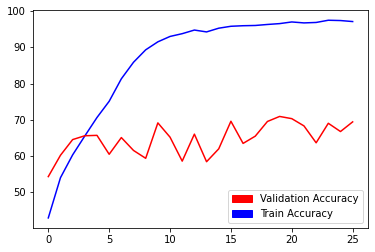

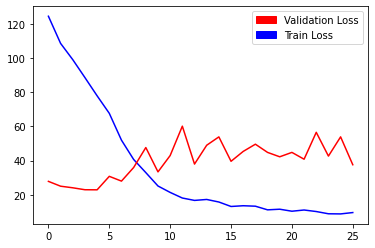

# Epoch : 26 /150
Valid_Prediction : [0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 2 0 0 2 1 1 0 1 0 0 0 2 0 0 2 0 0 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 2 2 0 2 0 2 0 0 0 0 0 0 0 2 1 0 0 1 0 0 0 0 2 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 2 0 0 0 1 0 1 0 0 2 1 0 1 1 2 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 0 1 0 2 1 0 0 0 0 0 2 2 0 0 0 0 0 0 2 0 1 0 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 0 2 0 0 0 2 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 2
 1 

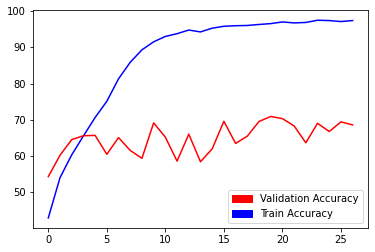

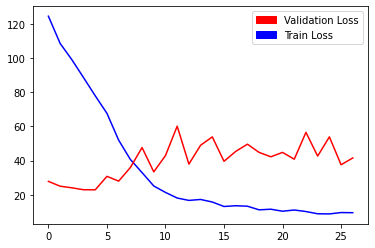

# Epoch : 27 /150
Valid_Prediction : [0 2 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 2 1 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 2
 1 

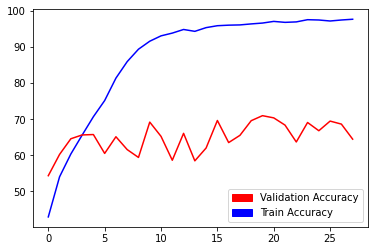

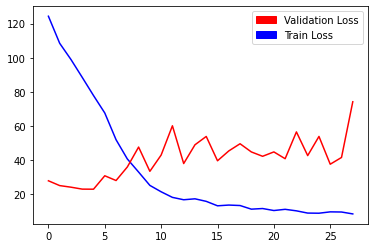

# Epoch : 28 /150
Valid_Prediction : [0 2 0 1 0 2 1 1 1 0 1 0 1 0 0 1 0 2 2 0 1 0 2 0 0 1 1 0 2 0 2 0 1 0 2 2 0
 0 1 0 0 2 1 0 2 1 1 2 1 2 0 0 2 2 1 2 2 0 0 2 1 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 2 1 2 2 1 1 0 2 0 1 2 1 0 0 0 2 1 0 1 1 0 0 2 0 2 1 0 1 2 0 0 1 2 0
 2 2 1 2 0 2 0 0 2 2 0 1 1 1 0 2 2 1 1 1 0 2 2 2 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 0 1 0 1 0 2 2 2 2 1 1 0 1 2 1 0 1 1 0 0 0 0 1 1 2 1 1 2 0 1 0 1 1
 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 2 0 1 1 1 1 1 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 1 0 2 0 0 0 2 0 0 1 0 1 2 2 1 1 1 2 2 0 1 1 0 2 0 2 1 0 0 0 1 0 2
 1 

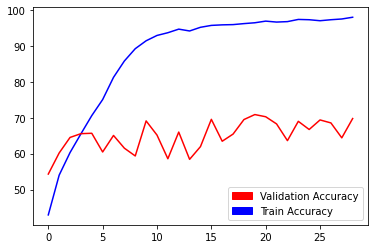

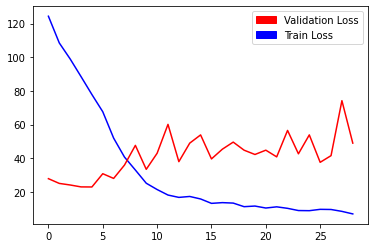

# Epoch : 29 /150
Valid_Prediction : [0 2 2 0 0 2 1 1 2 2 2 0 1 0 0 0 0 2 0 0 1 0 0 1 0 1 0 0 2 0 2 0 2 0 0 2 0
 0 0 0 1 2 0 0 2 1 2 0 2 2 0 0 2 2 0 2 0 0 0 1 1 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 2 2 2 0 1 2 0 0 2 0 2 2 0 2 1 0 2 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0
 2 2 0 0 0 2 0 0 2 0 0 0 1 0 0 2 2 2 1 0 0 2 2 2 2 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 2 0 2 2 0 2 0 1 0 2 0 0 0 1 2 0 0 2 0 1 0 2 0 0 2 0 2 2 1 1
 0 2 2 0 0 2 0 1 0 2 0 1 1 2 0 0 2 0 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 2 0 2 0 0 0 0 0 2 0 0 0 2 0 0 1 0 2 2 0 0 0 0 0 0 0 2 0 0 0 1 0 2
 0 

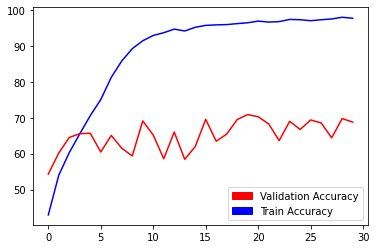

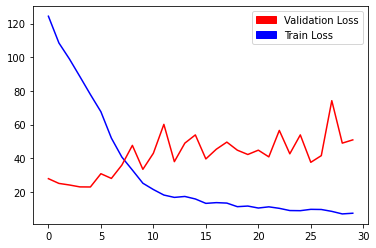

# Epoch : 30 /150
Valid_Prediction : [0 2 0 0 2 0 1 1 2 2 1 0 1 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 2 0 2 2 1 0 0 2 0
 0 0 2 0 2 0 0 2 1 0 0 0 2 0 0 2 2 0 0 0 0 2 2 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 2 0 2 2 2 2 2 0 2 0 2 2 1 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 2 0
 2 2 0 2 0 2 0 0 2 0 0 1 0 0 2 2 0 2 1 0 0 2 0 2 1 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 0 1 0 0 2 0 2 0 1 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 2 0 1
 1 2 1 0 0 2 0 1 0 2 0 0 1 0 0 0 2 2 2 0 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 2 0 0 0 0 2 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 

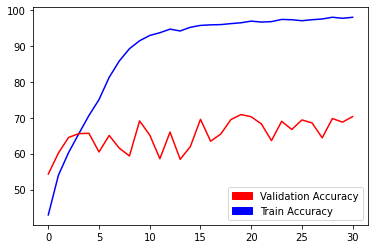

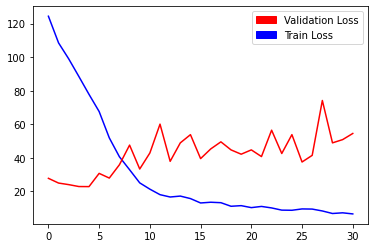

# Epoch : 31 /150
Valid_Prediction : [2 2 2 2 2 2 1 1 2 2 2 2 1 2 2 0 2 2 2 2 2 0 2 2 2 1 2 0 2 0 2 2 2 0 2 2 2
 0 2 2 0 2 2 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 0 2 0 2 1 0 2 1 0 2 2 0 2 1 2 0 2 2 2 2 2 2
 2 2 2 2 0 2 2 0 2 2 2 1 1 1 2 2 0 2 1 2 2 2 2 2 2 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 2 2 2 2 2 2 0 2 2 2 2 1 1 2 2 2 2 2 0 1 2 2 2 2 2 0 2 2 1 2 0 2 2 1 1
 2 2 2 2 2 2 2 0 0 2 2 1 1 2 2 2 2 2 2 2 1 0 2 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 2 0 2 2 0 2 2 2 2 2 2 2 1 0 2 2 2 2 1 2 2 0 0 1 1 2 2 2 2 2 0 2 0 1 2 2
 2 

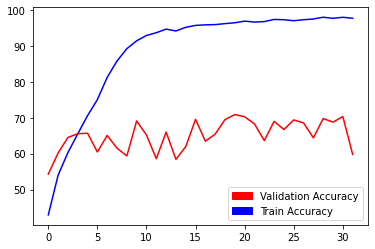

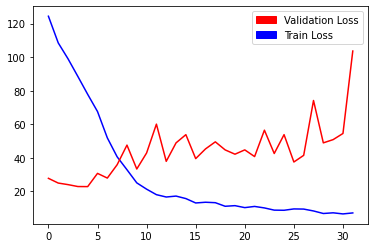

# Epoch : 32 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 2 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 2 0
 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 1 1 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 0 2 2 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 2
 0 

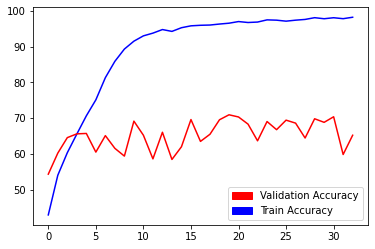

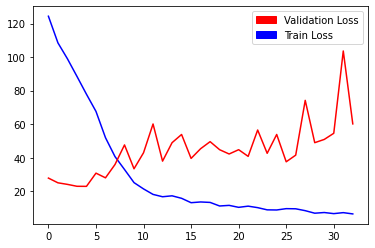

# Epoch : 33 /150
Valid_Prediction : [0 2 0 0 0 2 1 1 2 0 0 0 1 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 0
 0 0 0 0 2 0 0 2 0 0 0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 0 0 2 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 2 1 2 1 0 0 2 0 0 2 0 2 0 0 0 2 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 2 2 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 2 1 2
 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 2 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 2 0 0 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 1 0 2
 0 

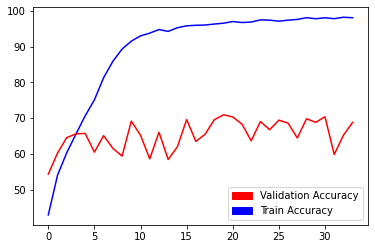

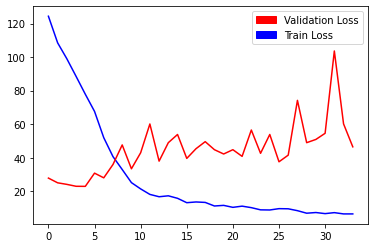

# Epoch : 34 /150
Valid_Prediction : [0 1 0 1 0 0 1 1 2 0 1 0 0 0 0 0 0 1 2 0 1 2 0 0 0 1 0 0 2 0 0 2 1 0 2 0 0
 0 0 0 0 2 0 0 2 1 2 0 1 2 0 0 1 2 0 2 0 0 2 2 1 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 2 0 2 2 2 1 2 0 0 2 0 2 1 0 0 0 0 0 0 0 1 0 0 0 0 2 1 2 0 0 0 0 0 2 0
 2 0 0 0 2 2 0 0 0 1 2 0 1 0 0 2 0 1 1 2 0 2 2 2 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 1 0 0 2 0 1 0 0 1 0 0 2 1 0 0 2 1 0 0 1 0 0 2 0 1 0 0 1 0 2 0 0 2 0 1
 1 2 1 0 0 0 1 1 0 1 0 0 1 2 0 0 2 0 1 0 0 0 0 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 1 0 2 2 0 0 2 0 2 1 2 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 2
 2 

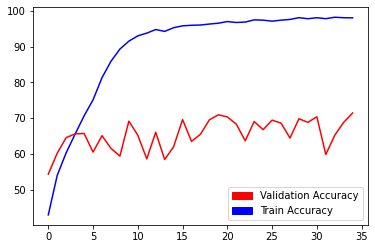

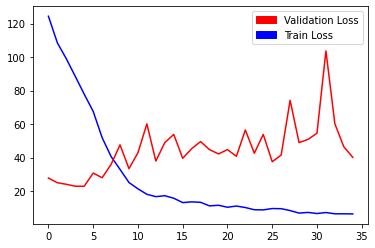

# Epoch : 35 /150
Valid_Prediction : [0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 2 0 0 0 1 0 0 0 0
 0 0 0 0 2 0 0 2 1 2 0 1 2 0 0 2 2 0 2 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0
 2 0 0 0 0 2 0 0 0 1 0 1 0 0 0 0 0 2 1 0 0 0 0 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 1 0 0 0 1 0 2 2 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 

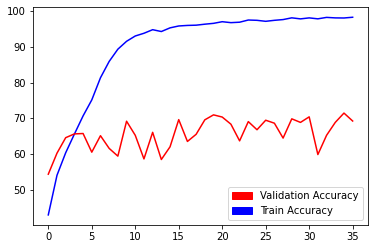

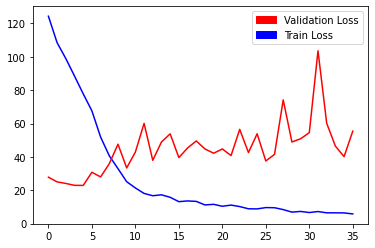

# Epoch : 36 /150
Valid_Prediction : [0 2 0 0 2 0 1 1 2 0 0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 0 2 0 2 0 2 2 2 0 2 0 0
 0 0 0 1 2 0 0 2 1 2 0 0 2 0 0 2 2 1 2 1 0 0 2 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 2 0 2 0 0 2 1 0 2 0 2 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 0 2 0
 2 0 0 0 0 2 0 0 2 1 2 1 1 0 0 2 0 1 1 1 0 2 2 2 1 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 2 1 0 2 1 0 1 1 1 0 2 2 0 0 0 2 0 0 0 0 1 0 0 1 1 0 0 2 2 0 0
 0 0 1 2 0 0 0 0 0 0 0 1 1 2 0 0 2 0 2 0 0 1 2 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 0 2 0 0 0 2 0 2 1 0 0 2 2 1 1 0 1 0 0 1 1 0 2 0 2 2 0 0 0 1 0 2
 0 

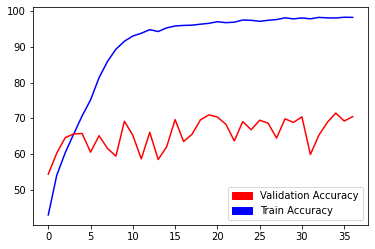

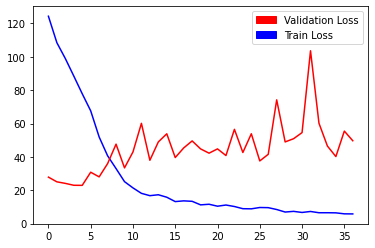

# Epoch : 37 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0
 0 0 2 0 2 0 0 2 1 2 0 0 2 0 0 2 2 0 2 1 0 0 0 1 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 0 2 0 0 0 0 0 0 0 2 0 2 0 0 0 0 1 0 0 0 2 0 2 0 0 1 0 0 0 0
 2 0 0 0 0 2 0 0 0 1 2 1 0 0 2 2 0 2 1 2 0 2 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 0 2 1 0 2 2 0 0 0 2 0 0 0 0 1 0 0 0 1 0 0 0 2 0 0
 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 0 0 2 2 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 0 0 2 1 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 2 0 0 0 0 1 0 0
 0 

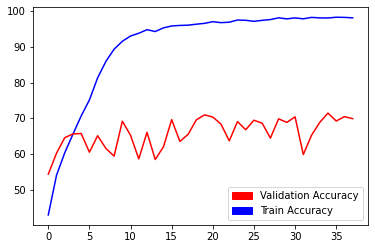

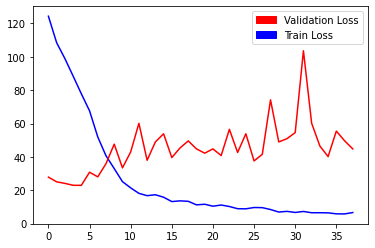

# Epoch : 38 /150
Valid_Prediction : [0 2 2 1 2 2 1 1 2 0 2 0 1 2 0 0 2 2 2 0 2 2 0 1 2 1 2 1 2 0 2 2 2 2 2 2 0
 0 2 1 1 2 0 0 2 2 2 2 2 2 0 0 2 2 0 2 1 0 2 2 2 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 2 2 2 2 2 2 2 1 2 2 1 0 2 0 2 1 2 1 0 2 1 0 0 2 2 2 0 2 1 2 2 2 0 2 0
 2 2 0 2 2 2 2 0 2 2 2 1 1 0 2 2 1 2 1 2 0 2 2 2 2 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 2 2 0 2 2 2 0 2 2 2 2 2 1 0 2 2 1 2 0 2 0 0 2 2 1 0 2 1 1 2 0 2 2 1 1
 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 0 2 2 1 2 2 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 2 0 2 2 0 0 2 2 2 1 2 2 0 2 0 1 2 2 0 2 1 1 2 2 0 2 2 0 2 0 1 0 2
 2 

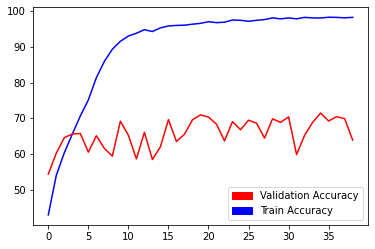

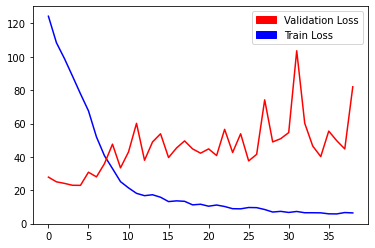

# Epoch : 39 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 2 0 2 0 1 0 0 0 0 2 0 0 2 0 0 0 0 2 2 0 2 0 0 0 2 0 0 2 0
 0 1 0 0 2 0 0 2 0 0 0 2 2 0 0 2 2 1 0 0 0 0 2 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 0 0 0 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 0 0
 2 0 0 0 0 2 0 0 2 1 0 0 1 0 0 2 0 2 0 2 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 0 0 1 0 2 2 0 0 0 1 0 0 0 0 1 0 0 0 0 2 0 0 0 1 1
 0 2 1 0 0 0 0 1 0 2 0 0 1 0 0 0 2 0 2 0 1 2 2 2 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 0 2 0 0 0 2 2 2 0 0 0 0 2 1 1 0 0 2 0 1 1 0 0 0 2 2 0 0 0 1 0 2
 0 

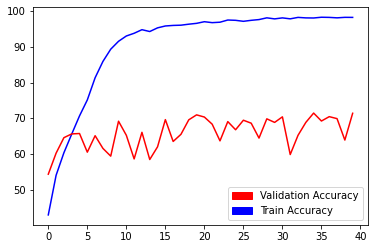

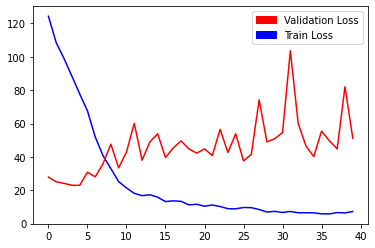

# Epoch : 40 /150
Valid_Prediction : [2 2 0 1 2 2 1 1 2 2 2 0 0 0 0 0 0 2 1 2 1 0 0 0 0 1 2 0 2 0 2 2 2 2 2 2 0
 0 2 0 0 2 2 0 2 1 2 2 1 2 0 0 2 2 2 2 0 0 0 2 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 2 2 2 2 2 2 2 0 2 1 2 0 0 0 0 0 0 1 0 2 1 0 0 0 0 2 1 2 0 0 0 2 2 2 0
 2 2 0 2 0 2 2 0 2 2 2 1 1 0 2 2 2 2 2 2 0 0 2 2 2 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 0 2 0 2 0 2 2 2 1 1 1 2 2 2 0 0 1 2 2 2 2 2 1 0 2 1 0 2 0 2 2 1 2
 1 2 1 0 0 2 1 1 2 2 0 0 1 1 2 2 2 2 1 2 0 0 2 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 2 0 0 2 0 2 2 2 0 2 2 2 1 2 1 0 2 1 1 2 1 1 0 2 1 2 2 0 2 2 0 2 0 2 0 2
 1 

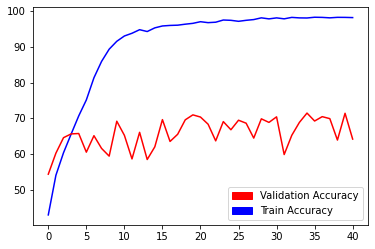

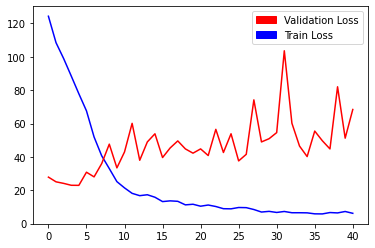

# Epoch : 41 /150
Valid_Prediction : [0 1 0 0 2 2 1 1 2 0 1 0 1 0 0 0 2 1 2 0 1 0 0 0 0 1 2 0 2 2 2 2 2 0 2 2 0
 0 2 0 0 2 1 0 2 2 2 2 2 2 0 0 2 2 1 2 0 2 0 2 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 2 0 2 2 2 2 2 2 0 2 2 2 0 1 0 0 0 2 0 0 0 1 0 0 2 2 2 0 2 0 0 0 0 0 2 0
 2 2 0 2 0 2 2 0 2 2 2 1 0 1 2 2 2 2 1 2 0 0 2 2 2 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 2 0 0 2 2 2 2 2 2 0 2 1 2 2 2 2 0 0 0 1 0 0 0 0 1 0 0 1 0 2 0 1 2 1 1
 1 0 2 0 0 0 2 1 0 1 0 0 1 2 1 2 2 2 1 2 0 0 0 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 2 0 0 1 0 2 2 0 0 2 2 2 1 2 2 0 2 1 1 2 2 0 0 1 1 2 2 0 2 2 0 0 0 0 0 2
 0 

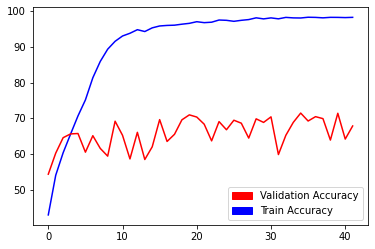

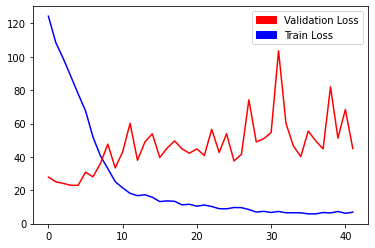

# Epoch : 42 /150
Valid_Prediction : [0 2 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 0
 0 0 0 0 2 0 0 2 0 0 0 1 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 2 0 0 2 0 2 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 2 0 0 0 0 2 0 1 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 2 1 0 0 0 0 0 0 1 2 1 1 0 0 0 2 0 2 0 0 0 2 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 

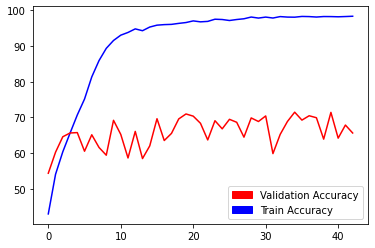

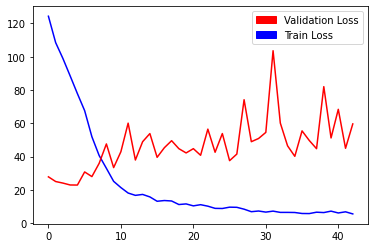

# Epoch : 43 /150
Valid_Prediction : [0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 0 0 2 0 2 0 2 2 0 1 2 2 0 2 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 2 1 0 0 2 2 0 2 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 2 0 0 2 0
 2 0 0 2 0 2 0 0 0 2 2 0 0 0 2 0 2 2 1 2 0 0 0 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 2 2 2 0 2 1 0 2 2 0 0 0 0 0 0 0 0 1 0 2 0 0 2 0 0 2 1 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 0 0 2 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 0 0 0 2 0 2 2 0 0 0 2 0 0 0 2 0 0 1 0 0 2 0 2 2 0 0 0 1 0 2
 0 

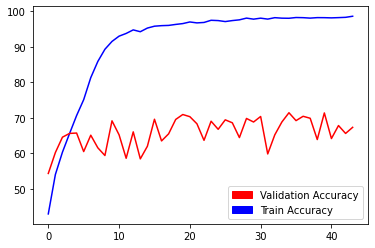

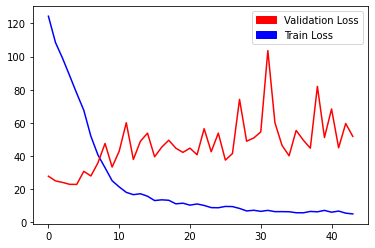

# Epoch : 44 /150
Valid_Prediction : [0 1 0 0 2 0 1 1 2 0 2 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 2 0 2 2 1 0 2 2 0
 0 0 0 0 2 1 0 2 1 2 0 1 2 0 0 2 2 0 2 0 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 2 0 0 2 2 2 1 2 0 2 1 1 0 1 0 0 0 2 1 0 0 1 0 0 0 0 2 1 2 2 0 0 0 0 2 0
 1 2 0 0 0 2 0 0 0 1 0 1 1 0 2 2 0 2 1 2 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 2 1 0 2 2 0 1 1 1 0 2 2 1 0 0 0 0 0 2 0 1 0 2 1 0 2 0 2 1 1 2
 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 2 2 0 1 2 0 0 0 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 1 0 2 2 0 0 0 0 0 1 0 1 0 2 1 1 1 2 0 0 1 1 0 2 0 2 1 0 0 0 1 0 1
 0 

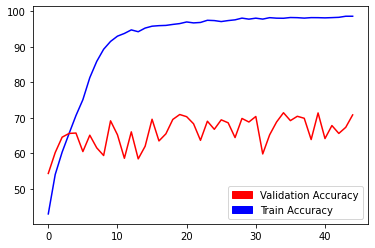

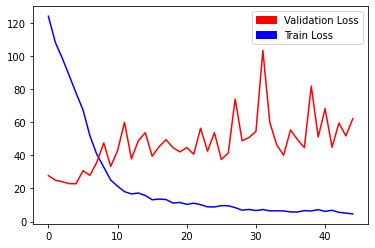

# Epoch : 45 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 2 0 2 0 2 0 2 2 0
 0 0 0 0 2 0 0 2 2 0 0 2 2 0 0 2 2 0 2 1 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 2 0 2 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0
 2 2 0 2 0 2 0 0 0 0 2 1 1 0 0 0 0 2 1 2 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 0 2 0 2 2 0 1 2 1 0 2 2 0 0 0 2 0 0 0 0 2 0 2 1 1 2 0 0 1 1 2
 0 2 2 2 0 0 0 1 0 2 0 1 1 0 0 2 2 0 2 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 0 0 0 0 0 0 1 0 1 0 2 0 1 0 2 2 0 2 0 0 0 0 2 2 0 0 0 1 0 2
 0 

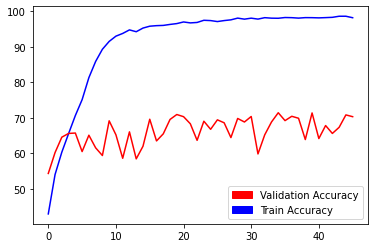

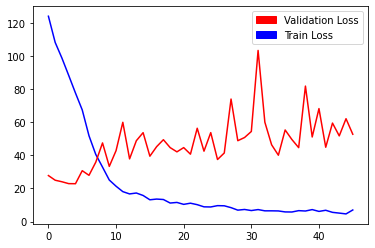

# Epoch : 46 /150
Valid_Prediction : [0 2 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 2 0 0 0 1 0 0 2 0
 0 0 0 0 2 0 0 2 1 2 0 0 2 0 0 2 2 1 0 0 0 0 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 2 2 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 2 0
 2 0 0 0 0 2 0 0 0 0 0 0 0 1 0 2 0 2 0 1 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 0 2 0 2 0 0 1 0 1 0 1 0 2 2 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 2 0 1 2
 1 0 1 0 0 2 0 0 0 1 0 1 1 0 0 0 2 0 1 0 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 2 0 0 0 0 0 0 1 0 1 0 2 1 1 0 0 0 0 1 1 0 0 0 2 0 0 0 0 1 0 2
 0 

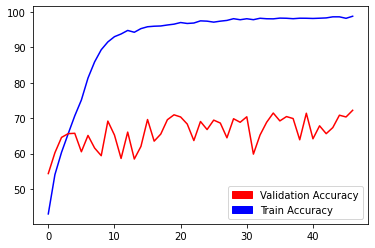

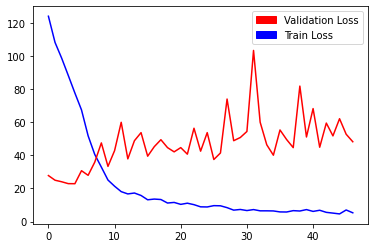

# Epoch : 47 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 2 2 0 1 0 0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 2 0 2 2 0
 0 0 0 0 2 1 0 2 2 1 0 1 2 0 0 2 2 1 0 1 0 0 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 2 2 2 2 2 2 0 0 0 1 2 1 0 0 0 2 1 0 0 0 0 0 0 0 2 1 2 0 2 1 0 0 2 0
 2 2 0 0 0 2 0 0 1 1 0 1 1 1 0 0 0 2 1 2 2 0 2 2 2 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 1 0 0 2 0 1 0 1 0 2 2 0 0 0 1 1 0 0 0 2 0 2 1 1 2 0 2 2 1 1
 1 0 2 2 0 0 0 0 2 2 0 1 1 2 0 1 1 0 1 0 0 0 1 0 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 2 0 0 0 1 0 2 1 2 1 0 2 1 1 1 2 2 0 1 1 0 2 0 2 2 0 0 0 1 0 1
 1 

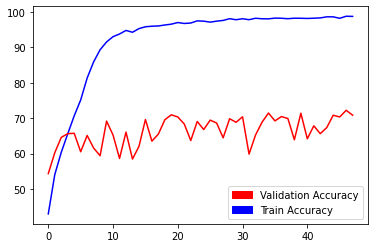

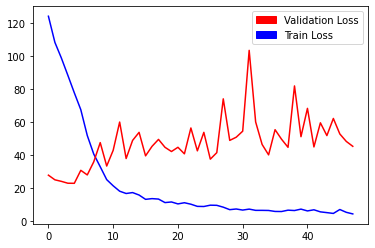

# Epoch : 48 /150
Valid_Prediction : [1 1 1 1 2 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 2 1 0 1 1 0 2 0 2 0 1 0 2 2 0
 0 0 0 0 2 1 0 2 1 2 0 1 2 0 0 2 2 1 2 2 0 0 1 1 2 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 2 2 0 1 1 2 2 0 0 1 0 0 0 2 1 0 0 0 0 0 0 2 2 1 2 0 2 0 0 1 2 0
 2 0 0 2 0 2 0 0 2 2 2 1 1 1 0 2 0 1 1 1 0 2 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 2 0 2 0 2 0 2 1 0 1 1 1 0 2 2 1 0 1 1 0 2 2 2 1 1 0 1 1 0 0 1 2 1 2
 1 2 1 2 0 2 0 1 0 1 1 1 1 2 0 1 2 0 1 0 1 2 0 2 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 1 2 2 2 0 1 2 0 1 1 0 1 0 2 1 1 0 2 0 0 1 1 2 2 0 2 1 0 0 0 1 0 1
 1 

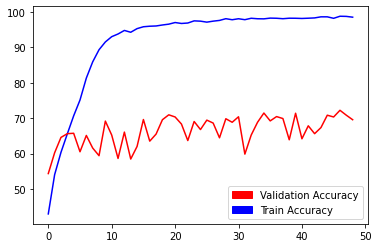

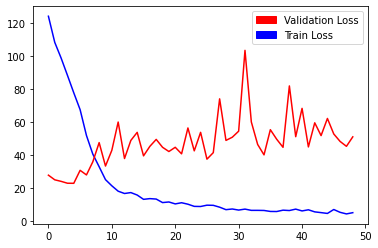

# Epoch : 49 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 2 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 2 2 0
 0 0 0 0 2 1 0 2 2 0 0 2 2 0 0 2 2 0 0 0 0 0 0 2 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 2 0 0 0 0 0 1 0 0 0 2 0 0 0 1 0 0 0 0 2 1 2 0 0 0 0 0 0 0
 2 2 0 0 0 2 0 0 0 0 0 1 1 0 0 0 0 2 1 2 0 0 2 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 0 1 0 2 2 0 0 1 1 0 2 2 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 2 1 1 2
 1 2 1 0 0 0 0 0 0 2 0 0 1 2 0 0 2 0 2 0 0 0 1 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 0 0 0 0 0 0 1 0 1 0 2 1 1 2 2 2 0 1 1 0 0 0 0 2 0 0 0 2 0 2
 1 

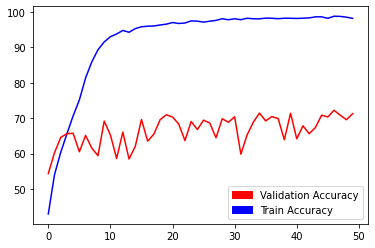

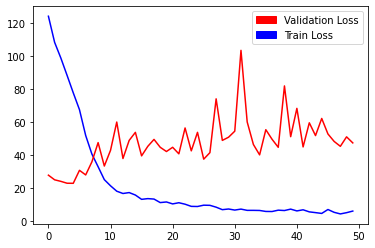

# Epoch : 50 /150
Valid_Prediction : [0 2 0 1 0 0 1 1 2 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 2 0 0 0 1 0 0 0 0
 0 1 0 0 2 0 0 2 1 0 0 1 2 0 0 1 2 0 0 0 0 0 1 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 0 0
 2 0 0 2 0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 0 0 0 0 0 0 2 0 1 1 1 0 2 2 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 2 0 2 0 1 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 2
 0 

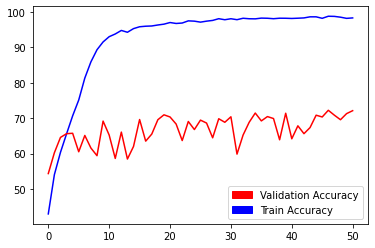

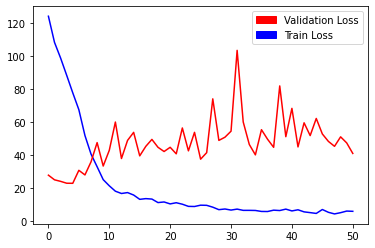

# Epoch : 51 /150
Valid_Prediction : [0 2 0 0 0 0 2 1 2 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 0 0 2 2 2 0 2 2 0 0 2 2 1 2 0 0 0 0 2 2 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 0 0 0 1 0 0 2 0 0 0 2 1 0 0 2 0 0 0 0 2 0 2 0 2 0 2 2 2 0
 2 2 0 2 0 2 2 0 0 2 0 1 0 0 0 2 0 2 1 2 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 1 0 0 0 0 2 0 2 2 0 2 2 2 0 2 2 0 0 0 1 0 0 0 0 2 0 2 2 0 2 0 2 2 1 2
 0 2 2 0 0 0 0 0 0 2 0 2 1 2 0 2 2 0 2 2 0 0 0 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 2 0 2 2 2 2 1 2 1 0 2 0 0 0 2 0 0 2 1 0 2 0 2 2 0 0 0 1 0 2
 2 

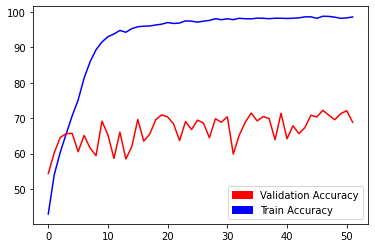

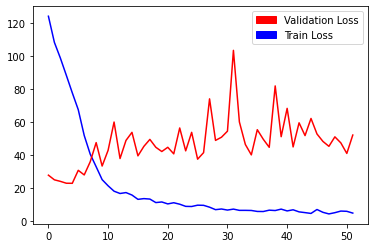

# Epoch : 52 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 2 2 0 1 0 0 0 0 0 1 0 2 0 2 0 2 0 0 2 0
 0 0 0 0 2 1 0 2 1 2 1 1 2 0 0 2 2 0 2 0 0 0 1 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 2 0 0 0 0 0 1 0 0 0 2 1 0 1 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 2 2 0 0 0 2 0 0 2 2 2 1 0 1 0 2 0 2 1 2 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 2 0 1 0 2 2 0 2 1 1 0 2 2 0 0 1 1 0 0 2 0 1 0 2 1 1 0 0 2 2 1 1
 1 1 1 1 0 0 0 1 0 1 0 1 1 2 0 0 2 0 1 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 0 2 1 0 0 2 2 2 1 0 1 0 2 0 1 0 2 0 0 1 1 0 2 0 2 1 0 0 0 1 0 2
 1 

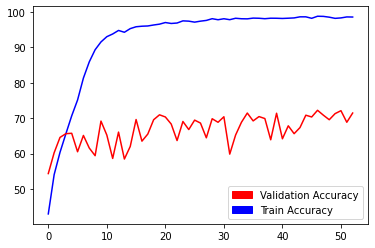

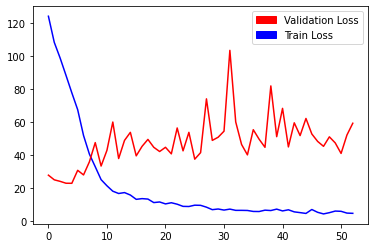

# Epoch : 53 /150
Valid_Prediction : [0 1 0 0 0 0 1 1 0 0 2 0 1 0 0 0 0 1 0 0 1 0 1 2 0 1 0 0 2 0 2 0 1 0 0 2 0
 0 0 0 0 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 1 0 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 2 2 2 2 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 1 2 0 0 0 0 0 0 0
 1 0 0 2 0 2 0 0 0 1 0 1 1 0 0 0 1 2 1 2 0 0 0 2 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 0 0 1 0 0 2 0 0 1 1 0 2 2 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 2
 0 0 2 0 0 0 0 0 0 2 0 2 1 2 0 0 1 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 2 0 2 1 0 0 0 1 0 1
 1 

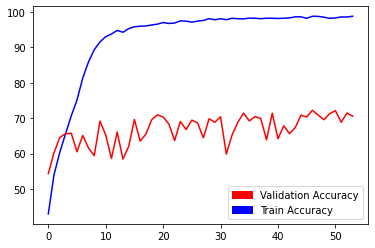

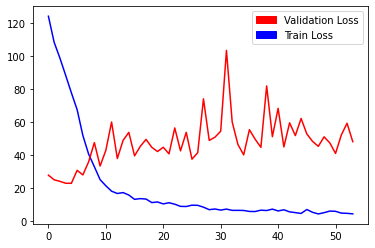

# Epoch : 54 /150
Valid_Prediction : [0 1 0 0 0 0 1 1 0 0 2 0 1 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 0
 0 0 2 0 2 2 0 2 0 0 0 1 2 0 0 2 2 0 2 0 0 0 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 2 0
 2 0 0 2 0 2 0 0 0 1 0 1 1 0 0 0 0 0 1 2 0 0 0 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 0 0 0 0 2 0 0 1 1 0 2 2 0 0 0 1 0 0 0 0 0 0 2 1 1 2 0 0 2 0 0
 1 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 2 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 2 0 0 0 2 0 0 0 0 0 0 2 0 1 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2
 0 

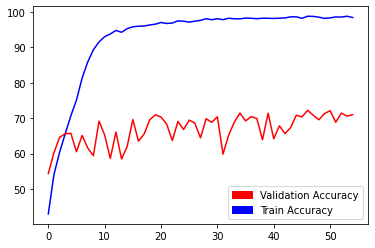

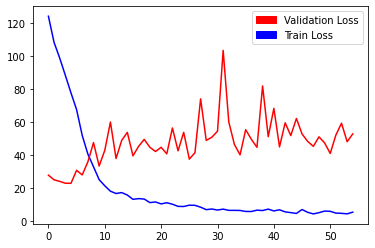

# Epoch : 55 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 2 0 2 0 0 0 0 0 0 1 0 0 1 0 0 2 0 2 0 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 0 0 2 2 0 0 1 2 0 0 2 2 0 2 0 0 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 2 2 2 2 2 0 0 0 0 0 0 1 0 0 0 2 0 0 2 1 0 0 0 0 2 1 2 0 0 0 0 0 2 0
 1 2 0 0 0 2 0 0 0 1 0 1 2 0 0 0 0 2 1 2 0 0 2 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 2 0 2 2 0 2 1 2 0 2 2 0 0 0 1 0 0 2 0 1 0 2 2 1 2 0 2 2 0 2
 2 0 0 0 0 0 0 0 0 2 0 0 1 2 0 0 2 0 2 0 0 0 0 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 2 0 2 2 0 0 2 2 2 1 0 2 0 2 1 0 0 2 0 0 0 0 0 0 0 2 1 0 0 0 1 0 2
 2 

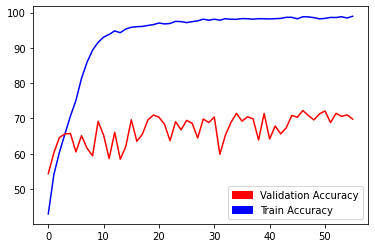

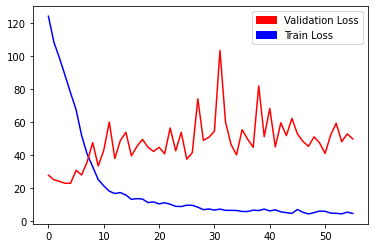

# Epoch : 56 /150
Valid_Prediction : [0 2 0 0 0 0 2 2 0 2 2 0 1 0 0 0 0 1 2 0 0 0 0 0 0 1 1 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 0 0 2 2 2 0 2 2 0 0 2 2 0 2 1 0 0 1 2 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 0 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 1 0 0 0 0 1 2 0 0 0 0 0 2 2
 1 2 0 2 0 2 0 0 0 2 2 0 2 0 2 2 2 2 1 2 0 0 2 2 2 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 0 2 0 0 1 1 0 1 2 0 2 2 0 0 0 2 0 0 0 0 1 0 2 2 0 0 0 0 2 0 2
 2 2 0 2 0 0 2 0 0 2 0 0 1 2 0 0 2 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 2 0 1 0 0 0 2 2 2 1 0 2 0 2 1 1 0 1 0 0 2 0 0 2 0 2 2 0 0 0 1 0 2
 0 

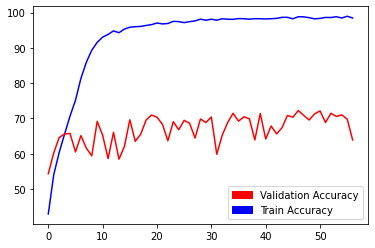

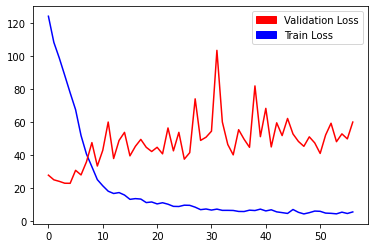

# Epoch : 57 /150
Valid_Prediction : [0 2 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 2 0 1 0 0 1 0 1 0 0 2 0 2 2 1 0 2 2 0
 0 0 0 1 2 1 0 2 1 2 0 1 2 0 0 2 2 1 0 1 0 2 1 0 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 2 0 0 2 2 2 2 2 0 0 1 1 0 1 0 2 0 0 0 0 1 0 1 0 0 0 2 1 2 0 2 0 0 2 2 0
 2 2 0 2 0 2 2 0 1 1 2 1 1 1 0 2 0 1 1 2 0 2 2 2 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 1 0 0 2 0 1 0 2 1 1 0 1 1 0 2 2 0 0 0 2 1 0 0 0 0 0 2 1 1 2 1 1 2 1 2
 2 0 1 1 0 0 0 0 0 2 0 0 1 1 0 2 2 0 2 0 0 0 0 0 2 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 0 0 0 2 2 2 1 2 2 0 2 1 1 2 0 2 2 1 1 0 2 0 2 2 0 0 0 1 0 1
 1 

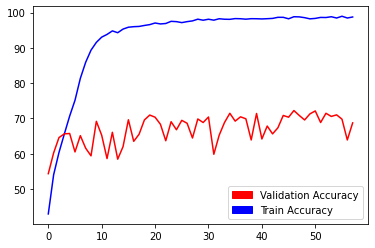

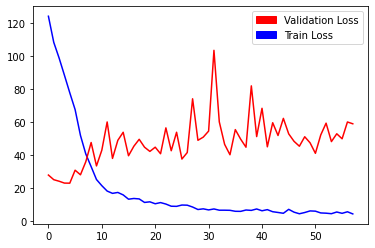

# Epoch : 58 /150
Valid_Prediction : [1 1 0 0 0 2 1 1 1 0 0 0 1 0 0 0 0 1 2 0 1 0 0 1 0 0 2 1 2 0 2 2 1 0 0 2 0
 0 0 0 0 2 0 0 2 1 2 0 2 2 0 0 2 2 0 0 1 0 0 1 2 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 0 2 1 0 0 0 1 2 1 0 2 0 0 0 0 2 0 0 0 0 2 2 0 2 0 2 1 0 0 2 0
 2 2 0 0 0 2 0 0 1 1 2 1 1 0 0 0 0 1 1 1 0 0 2 2 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 0 2 0 1 0 1 1 2 1 1 1 0 1 2 0 0 0 1 1 0 0 0 1 0 2 1 1 0 0 1 2 1 2
 1 0 1 1 0 0 1 0 1 2 0 1 1 2 0 1 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 0 2 1 0 0 2 0 2 1 0 1 0 0 1 1 0 2 0 0 1 1 0 2 0 1 1 0 0 0 1 0 1
 0 

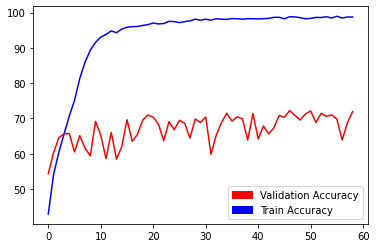

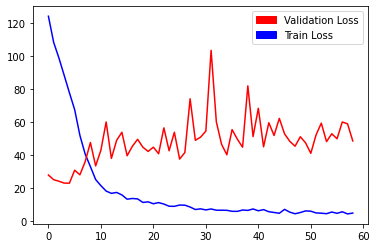

# Epoch : 59 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 2 0 2 2 1 0 0 2 0
 0 0 0 0 2 0 0 2 1 2 0 1 2 0 0 2 2 1 2 1 0 2 1 1 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 2 2 2 0 2 0 2 1 0 0 1 0 0 0 0 1 0 2 0 0 0 0 0 2 1 2 1 0 0 0 0 2 0
 2 2 0 0 0 2 0 0 0 1 2 1 1 0 2 2 0 1 1 2 0 2 2 2 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 0 1 0 0 0 2 2 0 1 1 1 0 2 2 0 0 0 1 0 0 2 0 1 0 0 1 1 0 0 1 2 1 1
 1 1 1 0 0 0 1 0 0 2 0 1 1 0 1 1 2 0 1 0 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 1 0 1 2 0 0 2 0 2 1 1 1 0 2 1 1 0 2 0 1 1 0 0 2 0 2 1 0 0 0 1 0 2
 1 

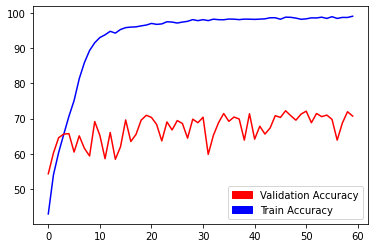

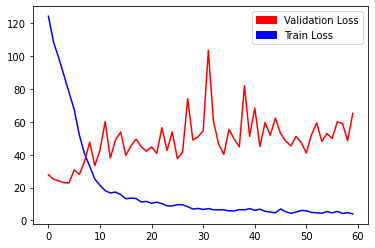

# Epoch : 60 /150
Valid_Prediction : [0 2 0 0 2 2 1 1 2 0 2 0 1 0 0 0 0 2 0 0 1 0 0 0 0 2 0 0 2 0 2 2 2 2 2 2 0
 0 0 0 0 2 0 0 2 1 2 0 2 2 0 0 2 2 0 2 1 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 2 2 2 2 2 2 2 2 1 0 1 0 0 0 2 0 0 2 2 0 0 0 0 2 0 2 2 2 0 0 0 2 0
 2 2 0 0 0 2 0 0 1 2 1 0 2 0 2 2 0 2 2 2 0 2 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 2 0 0 2 0 2 0 2 2 2 0 2 1 0 2 2 0 0 0 2 1 0 2 0 1 2 0 1 1 2 0 2 2 0 2
 1 2 2 2 0 0 0 1 0 2 0 0 1 2 0 0 2 0 1 2 0 1 0 2 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 2 0 0 2 0 2 0 0 0 2 0 2 0 0 2 0 2 2 1 0 2 0 0 2 0 0 2 0 2 2 0 0 0 2 0 2
 0 

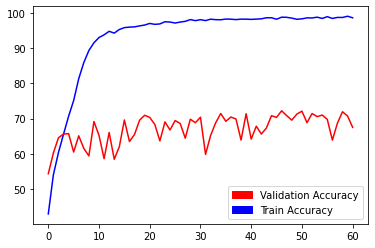

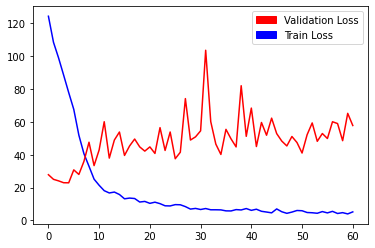

# Epoch : 61 /150
Valid_Prediction : [0 1 0 0 0 0 1 1 2 0 1 0 1 0 0 0 0 2 0 0 2 0 2 1 0 2 2 0 2 0 2 2 2 0 2 2 0
 0 0 0 0 2 1 0 2 2 2 0 2 2 0 0 2 2 1 2 1 0 0 1 2 2 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 2 2 0 0 0 0 2 2 0 2 0 2 1 0 1 0 0 0 0 0 2 1 2 0 2 0 0 0 2 0
 2 2 0 0 0 2 0 0 0 2 2 1 1 1 0 2 0 2 1 2 0 2 2 2 2 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 2 0 2 0 2 0 2 1 2 1 2 1 0 2 2 0 0 0 2 1 0 0 0 1 0 2 1 1 0 2 2 2 0 2
 1 2 2 2 0 2 1 0 0 2 0 0 1 2 0 0 2 0 1 0 0 0 1 0 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 2 2 0 2 0 0 1 0 0 0 1 0 1 0 2 2 1 2 2 2 0 1 1 0 2 2 2 2 0 0 0 1 0 2
 1 

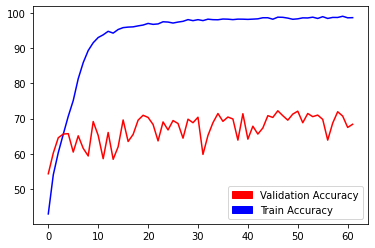

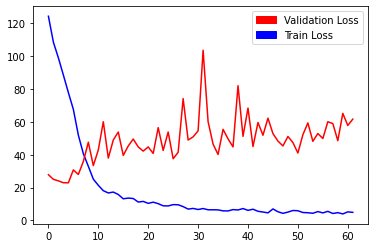

# Epoch : 62 /150
Valid_Prediction : [0 2 0 0 0 0 2 1 0 1 1 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 1 0 2 0 0 0 1 0 2 2 0
 0 0 0 0 2 1 0 2 2 2 0 0 2 2 0 2 2 0 2 0 0 0 1 1 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 2 0 2 2 2 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 0 0 0 0 0
 2 2 0 2 0 2 0 0 2 2 2 1 1 0 0 2 0 1 1 0 0 2 2 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 2 2 0 0 0 1 0 0 0 0 1 0 2 1 0 0 0 0 2 0 0
 1 0 2 0 0 0 0 2 0 2 0 1 1 2 0 0 2 0 1 0 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 2 2 0 0 1 0 0 0 1 0 1 0 2 0 1 0 1 0 0 1 0 0 0 0 2 1 0 0 0 1 0 2
 1 

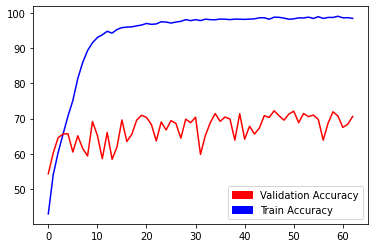

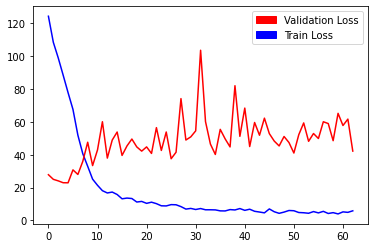

# Epoch : 63 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 2 0
 0 0 0 0 2 0 0 2 1 2 0 2 2 0 0 2 2 1 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 0 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 2 0
 1 0 0 0 0 2 0 0 0 2 0 0 0 1 0 0 0 1 1 2 0 2 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 2 2 0 0 0 1 0 2 0 0 1 0 0 1 1 0 0 2 0 1 0
 1 0 0 2 0 0 0 0 0 1 0 0 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 0 0 2 1 0 1 0 0 1 1 0 1 0 0 1 0 0 2 0 0 2 0 0 0 0 0 2
 0 

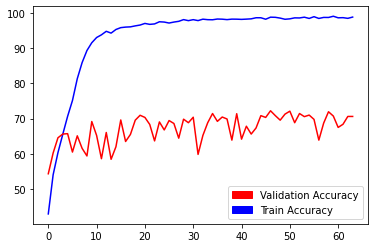

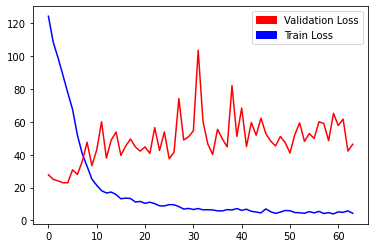

# Epoch : 64 /150
Valid_Prediction : [0 2 0 2 0 0 1 1 2 0 2 0 1 0 0 0 0 2 2 0 2 0 0 1 0 1 0 0 2 0 2 0 1 0 2 2 0
 0 0 0 0 2 1 0 2 1 2 0 2 2 0 0 2 2 1 2 0 0 0 2 1 0 0 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 2 2 2 0 2 0 0 0 0 0 0 0 0 2 0 2 1 0 2 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 2 2 0 0 0 2 0 0 0 0 0 1 1 1 0 2 0 2 1 2 0 0 2 2 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 1 0 2 1 0 2 2 1 0 2 2 0 0 0 2 2 0 0 0 1 0 2 1 1 2 0 2 1 0 1
 1 2 2 0 0 0 0 0 0 2 0 1 1 2 0 1 2 0 2 0 0 0 2 2 0 2 2]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 0 2 2 0 0 2 2 2 1 0 1 0 2 1 1 0 2 2 0 1 0 0 2 0 0 2 0 0 0 1 0 2
 0 

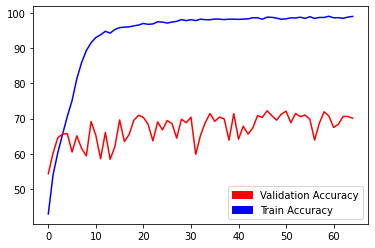

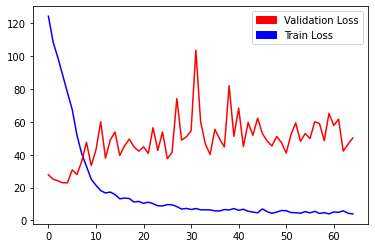

# Epoch : 65 /150
Valid_Prediction : [0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 2 0
 0 0 0 0 2 0 0 2 1 0 0 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 2 2 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0
 2 0 0 2 0 2 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 2 0 2 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 2 1 0 0 0 1 0 0 2 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 1 2 0 0 0 0 0 0 1 0 1 1 0 0 0 2 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 0 2 0 0 0 2 0 2 1 0 1 0 2 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 2
 1 

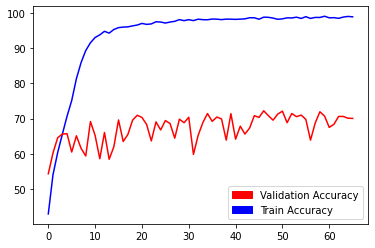

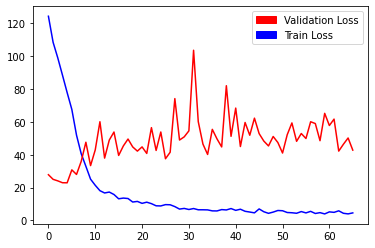

# Epoch : 66 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 2 0
 0 0 0 0 2 0 0 2 0 2 0 2 2 0 0 2 2 0 0 0 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 2 0
 2 2 0 2 0 0 0 0 0 0 0 0 1 0 2 2 0 2 1 0 0 0 0 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 2 0 0 0 0 0 0 2 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 2 0 2
 0 0 2 2 0 0 0 0 0 2 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 2 0 0 0 0 0 1 0 0 0 0 2 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0
 0 

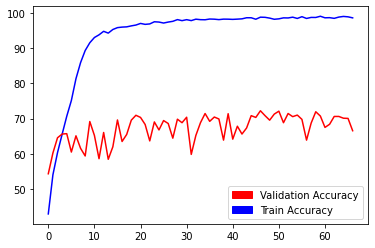

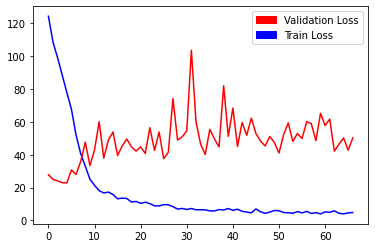

# Epoch : 67 /150
Valid_Prediction : [0 2 0 1 0 0 0 1 1 0 2 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 2 0 2 0 2 2 1 0 0 2 0
 0 0 0 0 2 0 0 2 1 2 0 1 2 0 0 2 2 1 0 0 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 2 2 2 1 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 0 2 1 2 0 0 0 2 0
 2 2 0 0 0 2 0 0 2 0 0 1 0 0 0 0 0 2 1 2 0 0 2 2 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 2 0 0 0 2 2 0 1 0 1 0 2 2 0 0 0 1 0 0 0 0 0 0 2 1 0 0 0 0 2 1 2
 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 2 0 1 1 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 2 0 2 0 0 0 0 0 2 0 0 2 0 0 1 1 1 2 0 0 0 0 0 2 0 0 1 0 0 0 2 0 2
 0 

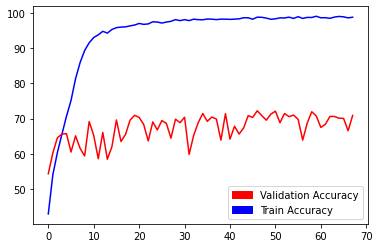

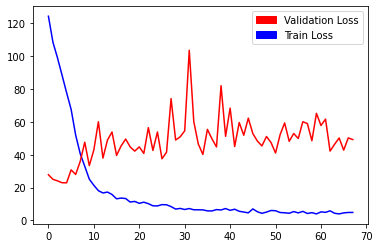

# Epoch : 68 /150
Valid_Prediction : [0 2 2 0 2 0 1 1 2 0 2 1 1 0 0 0 0 1 0 0 2 0 0 2 0 1 0 0 2 1 2 0 1 0 0 2 0
 0 2 0 0 2 0 0 2 1 2 0 1 2 2 0 2 2 1 0 0 0 0 1 1 0 2 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 2 2 2 2 2 0 0 0 1 1 0 1 0 2 0 2 1 0 0 0 1 0 0 0 2 2 2 1 0 0 0 0 2 0
 2 2 0 2 0 2 0 0 2 0 2 1 1 1 0 0 2 2 1 2 0 2 2 2 2 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 0 1 0 2 1 0 1 1 1 0 2 2 0 0 0 2 1 0 0 0 1 0 2 1 1 2 0 1 2 1 2
 1 0 1 0 0 0 0 1 0 2 0 1 1 1 0 1 2 0 2 0 0 0 0 2 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 1 0 1 2 0 0 2 0 2 1 1 1 0 2 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 

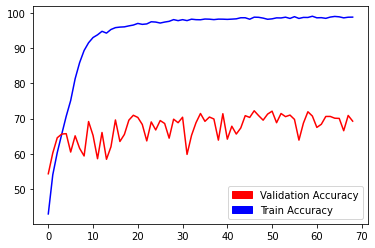

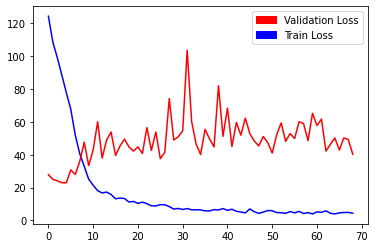

# Epoch : 69 /150
Valid_Prediction : [0 1 0 1 2 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 2 0 0 0 2 0 0 0 0
 0 0 0 0 2 0 0 2 1 2 0 1 2 0 0 2 2 1 2 0 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 2 2 2 0 0 2 1 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 2 1 2 0 2 0 0 0 2 0
 1 2 0 0 0 2 0 0 0 1 2 1 1 1 0 2 1 1 1 2 0 0 2 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 1 0 0 0 2 0 0 0 0 2 0 1 0 1 0 2 2 0 0 0 1 1 2 2 0 1 0 2 1 1 2 0 1 2 1 1
 1 2 1 0 0 0 0 0 0 1 0 0 1 1 1 0 2 0 2 0 1 0 2 0 0 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 1 2 0 0 0 0 0 2 0 0 1 0 0 1 1 0 2 0 0 1 0 0 2 0 2 1 0 0 0 1 0 2
 0 

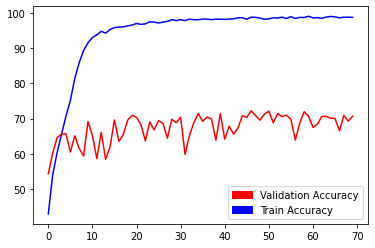

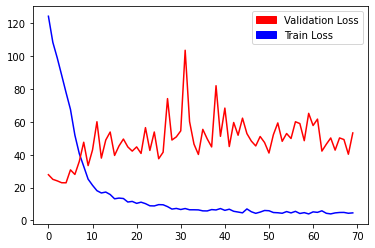

# Epoch : 70 /150
Valid_Prediction : [0 2 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 2 1 0 0 2 0 0 0 0
 0 1 0 0 2 1 0 2 1 0 0 2 2 2 0 2 2 1 0 0 0 0 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 2 2 2 2 2 0 0 1 0 0 1 0 0 0 2 1 0 1 0 0 0 0 0 2 1 2 0 0 0 0 0 2 0
 2 2 0 0 0 0 0 0 0 0 2 0 1 1 0 0 1 2 1 1 0 0 2 2 1 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 1 0 1 0 2 2 0 0 0 1 0 2 0 0 1 0 2 1 1 0 0 2 2 1 1
 1 0 0 0 0 0 0 1 0 2 0 0 1 2 0 0 2 0 1 0 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 1 1 0 0 0 2 0 2 0 0 1 0 2 0 0 0 2 0 0 1 0 0 2 0 2 1 0 0 0 1 0 2
 0 

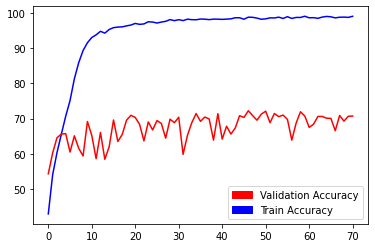

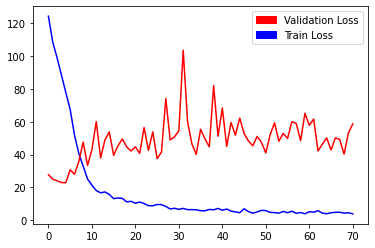

# Epoch : 71 /150
Valid_Prediction : [0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 2 0 0 0 2 0 0 0 0
 0 0 0 0 2 0 0 2 1 0 0 0 2 0 0 2 2 0 2 0 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0 0 2 0
 1 0 0 0 0 2 0 0 0 1 2 0 0 0 2 0 1 2 1 2 0 0 2 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [2 0 0 0 0 2 0 0 0 0 2 0 1 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 1 2 0 2 2 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 2 0 2 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 0 1 0 0 0 0 0 2 1 0 1 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 1 0 2
 0 

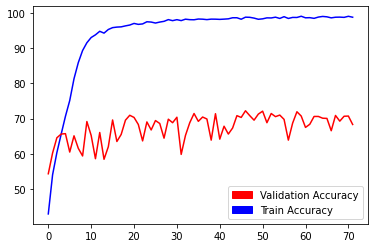

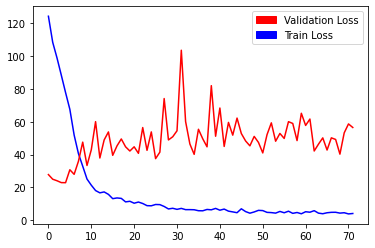

# Epoch : 72 /150
Valid_Prediction : [0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 2 0 0 0 1 0 0 2 0
 0 0 0 0 2 1 0 2 1 0 0 1 2 0 0 2 2 1 0 0 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0
 0 2 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 2 0 0 2 0 1 2 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 0 2 0 1 0 0 1 0 1 0 1 0 0 2 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 2 1 1
 0 2 1 0 0 0 0 1 0 2 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 0 2 2 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 2
 0 

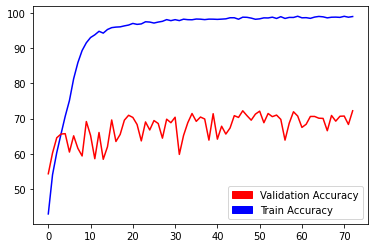

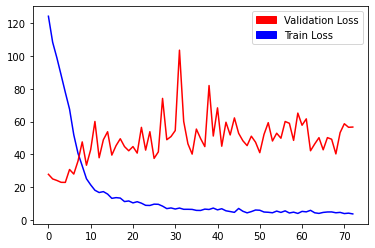

# Epoch : 73 /150


In [ ]:
# Learning
acc_t = []
acc_v = []
lss_t=[]
lss_v=[]
print('***START EPOCH***')

for epoch in range(150):
    print('# Epoch : {} /150'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)
    lss_t.append(loss_t)
    lss_v.append(loss_v)

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()
    
    plt.plot(range(len(lss_t)), lss_t, 'b', range(len(lss_v)), lss_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Loss')
    red_patch = mpatches.Patch(color='red', label='Validation Loss')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [ ]:
# Path for (unlabeled) test data
test_path = '/content/drive/MyDrive/FashionClassification/Test/'

In [ ]:
import re
def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]

In [ ]:
# Prepare test data set

data=[]
label=[]

files = os.listdir(test_path)
files.sort(key=num_sort)

for f in files:
    img = Image.open(test_path+f)
    #img = img.resize((224, 224))
    one_img = np.asarray(np.float32(img))
    norm_img =(one_img-np.min(one_img))/(np.max(one_img)-np.min(one_img))
    data.append(norm_img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
    label.append(0)    # dummy label for preparing dataloader

        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

test_X = torch.from_numpy(data)
test_Y = torch.from_numpy(label)

test_X = test_X.type(torch.cuda.FloatTensor)
test_Y = test_Y.type(torch.cuda.LongTensor)

test_dataset = TensorDataset(test_X,test_Y)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
print(test_X.shape, test_Y.shape)

In [ ]:
# evaluation
model.eval()
f_pred = []

with torch.no_grad():
      for inputs, labels in test_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        output = model(inputs)

        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())

        f_pred.extend(pred.tolist())

In [ ]:
# converting 0/1/2 label value into Resort/Retro/Sporty

for index, value in enumerate(f_pred):
  if value==0:
    f_pred[index]='Resort'
  elif value==1:
    f_pred[index]='Retro'
  else:
    f_pred[index]='Sporty'

In [ ]:
# Submission file
img_files = [i for i in range(len(f_pred))]
submission = pd.DataFrame(index = range(0,len(f_pred)), columns = {'img','class'})
submission['img'] = img_files
submission['class'] = f_pred

In [ ]:
submission

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/home/miil/DISK/bosoung/jiho/FashionClassification/VGG19')

In [ ]:
#pip install torchsummary

In [ ]:
# summary(model, input_size=(3, 224, 224))